In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
# from qick_lib.qick import *
%pylab inline

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from qick import *
from qick.pyro import make_proxy

soc, soccfg = make_proxy(ns_host="192.168.1.161", ns_port=8000, proxy_name="rfsoc")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8000
rfsoc PYRO:obj_7a5206692c854985a0ffed358e8841e0@192.168.1.161:35677
QICK running on ZCU216, software version 0.2.289

Firmware configuration (built Sat Sep 28 22:15:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 i

In [13]:
# DAC Signal Generating Channels
GEN_CH0 = 0
GEN_CH1 = 1
GEN_CH2 = 2
GEN_CH3 = 3
GEN_CH4 = 4
GEN_CH5 = 5
GEN_CH6 = 6
GEN_CH7 = 7
GEN_CH8 = 8
GEN_CH9 = 9
GEN_CH10 = 10
GEN_CH11 = 11
GEN_CH12 = 12
GEN_CH13 = 13
GEN_CH14 = 14
GEN_CH15 = 15

# ADC Readout Channels
RO_CH0 = 0
RO_CH1 = 1
RO_CH2 = 2
RO_CH3 = 3
RO_CH4 = 4
RO_CH5 = 5
RO_CH6 = 6
RO_CH7 = 7
RO_CH8 = 8
RO_CH9 = 9

# Time and Frequency
TRIG_TIME = 0.00 # [us]
FREQ = 4800  # 2963.586 # 3200 # [MHz] # 
GAIN = 0.1



## Single pulse for reseting channel

In [50]:
###########
# Program
###########

class ContinuousPulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        # self.declare_gen(ch=gen_ch, nqz=2)
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        self.declare_gen(ch=gen_ch, nqz=2, mixer_freq=cfg['mixer_freq'])
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=FREQ, gen_ch=gen_ch)
        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=1.0, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'],
                      )
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        
exp_config = {
    'gen_ch': 0,
    'ro_ch': 0,
    'freq': 4500,
    'trig_time': 0,
    'ro_len': 1.9,
    'gain': 0.1, # 0.1,
    'mixer_freq': 4500,
     }

###################
# Run the Program
###################

prog =ContinuousPulse(soccfg, reps=1, final_delay=0.5, cfg=exp_config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)

generator 0 doesn't have a digital mixer, but mixer_freq was defined


  0%|          | 0/1 [00:00<?, ?it/s]

## Continuous Pulse sequence working with the V2 version.

In [49]:
###########
# Program
###########

class ContinuousPulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=2)
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        # self.declare_gen(ch=gen_ch, nqz=2, mixer_freq=cfg['mixer_freq'])
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=FREQ, gen_ch=gen_ch)
                               
        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        mode = ["oneshot", "periodic"][cfg["out_en"]]

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=1.0, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=cfg['gain'],
                       mode=mode, stdysel="last"
                      )
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        
exp_config = {
    'gen_ch': 0,
    'ro_ch': 0,
    'freq': 4000,
    'trig_time': 0,
    'ro_len': 1.9,
    'gain': 0.1, # 0.1,
    'mixer_freq': 4500,
     }

###################
# Run the Program
###################

# prog =ContinuousPulse(soccfg, reps=1, final_delay=0.5, cfg=exp_config)
# iq_list = prog.acquire_decimated(soc, soft_avgs=1000)

def manualTune(out_en=1, **kwargs):
    exp_config.update(kwargs)
    config = {**exp_config, "out_en": out_en}
    prog =ContinuousPulse(soccfg, reps=1, final_delay=0.5, cfg=config)
    # iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
    iq_list = prog.acquire_decimated(soc, soft_avgs=1)
    if config["out_en"] == 0:
        print(dict(config), sort_dicts=False)


if __name__ == "__main__":
    manualTune(out_en=1, skewPhase=90, IQScale=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

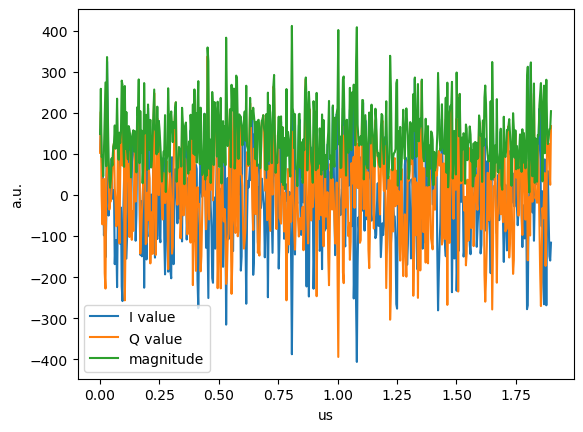

In [32]:
iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

## Attempting to build this program for mux channel - previously it did not work... still doesn't I think


In [81]:
###########
# Program
###########

class ContinuousPulse(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, ro_ch=ro_chs[0], 
                         mixer_freq=7000,
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)
        
        mode = ["oneshot", "periodic"][cfg["out_en"]]

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3],
                       mode=mode, stdysel = 'last',
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
exp_config = {'gen_ch': GEN_CH10,
          'ro_chs': [RO_CH2, RO_CH3, RO_CH4, RO_CH5],
          'pulse_freqs': [7150.2, 7172.0, 7204.8, 7229.5 ],
          'pulse_gains': [1.0]*4,
          'pulse_phases': [0.0]*4,
          'ro_phases': [0.0]*4,
          'trig_time': 0.4,
          'pulse_len': 1.0,
          'ro_len': 1.9,
         }

###################
# Run the Program
###################

# prog =ContinuousPulse(soccfg, reps=1, final_delay=0.5, cfg=exp_config)
# iq_list = prog.acquire_decimated(soc, soft_avgs=1000)

def manualTune(out_en=1, **kwargs):
    exp_config.update(kwargs)
    config = {**exp_config, "out_en": out_en}
    prog =ContinuousPulse(soccfg, reps=1, final_delay=0.5, cfg=config)
    # iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
    iq_list = prog.acquire_decimated(soc, soft_avgs=1)
    if config["out_en"] == 0:
        print(dict(config), sort_dicts=False)


if __name__ == "__main__":
    manualTune(out_en=1, skewPhase=90, IQScale=1)

generator 10 doesn't support phase config, but mux_phases was defined


RuntimeError: ('unsupported pulse parameter(s)', {'stdysel', 'mode'})

Text(0, 0.5, 'dBm')

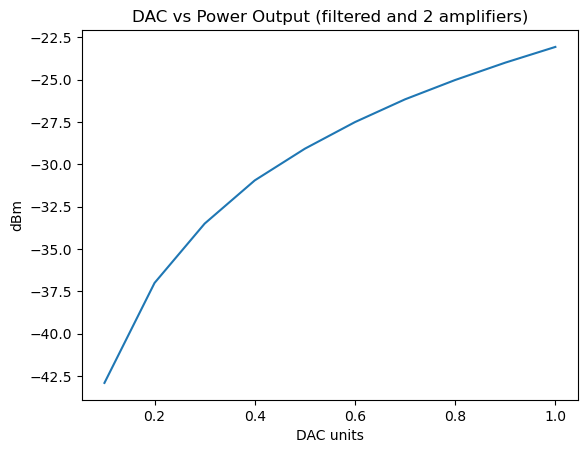

In [30]:
# Channel 4 power dependence
import numpy as np
import matplotlib.pyplot as plt

dac_gain = np.arange(0.1, 1.1, 0.1)
power_output = [-42.9, -37 , -33.5,  -30.95, -29.08, -27.51, -26.166, -25.026, -24.002, -23.074]

plt.plot(dac_gain, power_output)
plt.title('DAC vs Power Output (filtered and 2 amplifiers)')
plt.xlabel('DAC units')
plt.ylabel('dBm')
